In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
patients = pd.read_csv('patients.csv')
appointments = pd.read_csv('appointments.csv')
engagement = pd.read_csv('engagement.csv')
lab_results = pd.read_csv('lab_results.csv')

In [3]:
engagement_summary = engagement.groupby('patient_id').agg({
    'action_count': 'sum',
    'action_type': 'count',
    'date': 'nunique'
}).reset_index()
engagement_summary.columns = ['patient_id', 'total_actions', 'total_interactions', 'unique_days']

In [4]:
data = patients.merge(engagement_summary, on='patient_id', how='left')
data = data.fillna(0)

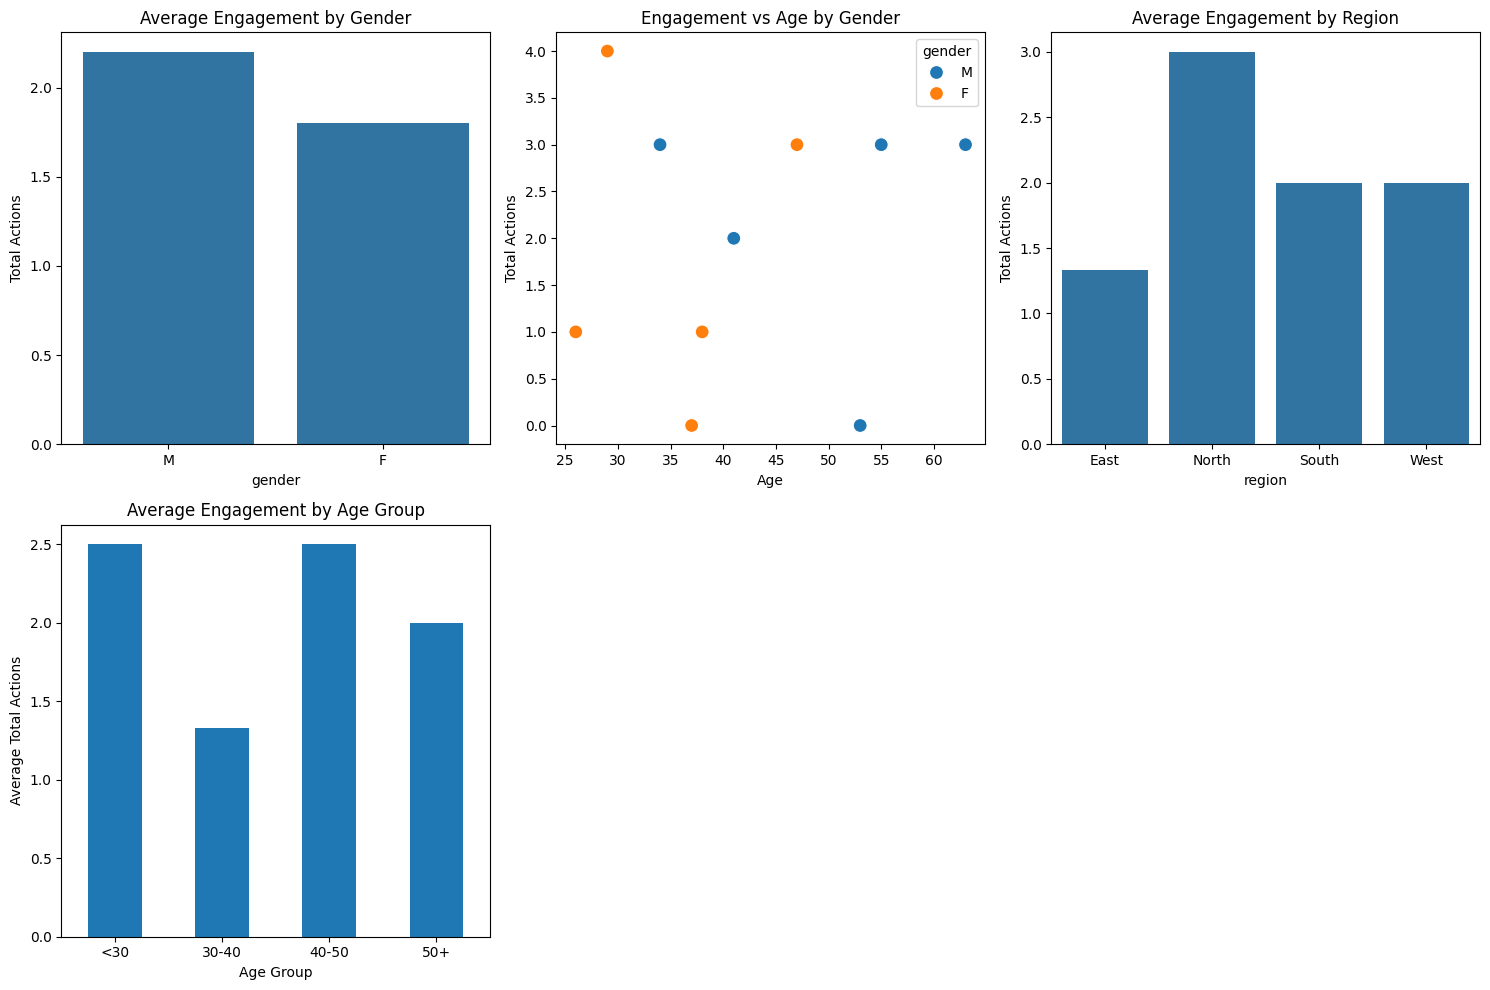

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.barplot(data=data, x='gender', y='total_actions', ci=None)
plt.title('Average Engagement by Gender')
plt.ylabel('Total Actions')

plt.subplot(2, 3, 2)
sns.scatterplot(data=data, x='age', y='total_actions', hue='gender', s=100)
plt.title('Engagement vs Age by Gender')
plt.xlabel('Age')
plt.ylabel('Total Actions')

plt.subplot(2, 3, 3)
sns.barplot(data=data, x='region', y='total_actions', ci=None)
plt.title('Average Engagement by Region')
plt.ylabel('Total Actions')

plt.subplot(2, 3, 4)
age_groups = pd.cut(data['age'], bins=[0, 30, 40, 50, 100], labels=['<30', '30-40', '40-50', '50+'])
engagement_by_age = data.groupby(age_groups)['total_actions'].mean()
engagement_by_age.plot(kind='bar')
plt.title('Average Engagement by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Total Actions')
plt.xticks(rotation=0)


plt.tight_layout()
plt.show()

In [9]:
appointment_features = appointments.groupby('patient_id').agg({
    'appointment_id': 'count',
    'attended_flag': lambda x: (x == 'N').sum()
}).reset_index()
appointment_features.columns = ['patient_id', 'total_appointments', 'no_shows']

In [10]:
provider_counts = appointments.groupby(['patient_id', 'provider_type']).size().unstack(fill_value=0)
provider_counts.columns = [f'appointments_{col}' for col in provider_counts.columns]
provider_counts = provider_counts.reset_index()

In [11]:
lab_features = lab_results.groupby('patient_id').agg({
    'diagnosis_flag': lambda x: (x == 'Positive').sum()
}).reset_index()
lab_features.columns = ['patient_id', 'positive_diagnoses']

In [12]:
ml_data = patients.merge(engagement_summary, on='patient_id', how='left')
ml_data = ml_data.merge(appointment_features, on='patient_id', how='left')
ml_data = ml_data.merge(provider_counts, on='patient_id', how='left')
ml_data = ml_data.merge(lab_features, on='patient_id', how='left')
ml_data = ml_data.fillna(0)

In [13]:
ml_data['attendance_rate'] = (ml_data['total_appointments'] - ml_data['no_shows']) / ml_data['total_appointments'].replace(0, 1)
ml_data['will_miss_next'] = (ml_data['no_shows'] > 0).astype(int)

In [14]:
le_gender = LabelEncoder()
le_region = LabelEncoder()
ml_data['gender_encoded'] = le_gender.fit_transform(ml_data['gender'])
ml_data['region_encoded'] = le_region.fit_transform(ml_data['region'])

In [15]:
ml_data['signup_days_ago'] = (pd.Timestamp('2025-09-01') - pd.to_datetime(ml_data['signup_date'])).dt.days

In [16]:
feature_columns = ['age', 'gender_encoded', 'region_encoded', 'total_actions',
                  'total_interactions', 'unique_days', 'total_appointments',
                  'appointments_GP', 'appointments_Specialist', 'appointments_Therapist',
                  'positive_diagnoses', 'signup_days_ago', 'attendance_rate']

X = ml_data[feature_columns]
y = ml_data['will_miss_next']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [19]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [20]:
print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Will Attend', 'Will Miss']))

Model Accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

 Will Attend       0.67      1.00      0.80         2
   Will Miss       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



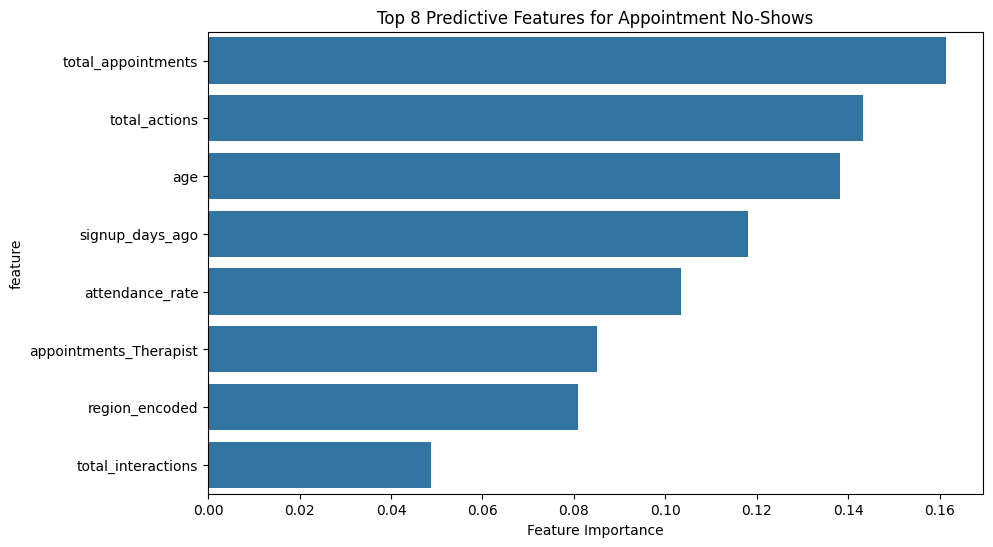

In [21]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(8), x='importance', y='feature')
plt.title('Top 8 Predictive Features for Appointment No-Shows')
plt.xlabel('Feature Importance')
plt.show()